# **ARMA and Linear Processes**

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import autocorrelation_plot
import os
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from prophet import Prophet 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
data = 'data/'

class CFG:
    img_dim1 = 12
    img_dim2 = 7
    fontsize = 9
    marker = 3.5
    lines = 2

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})    

## **Basic Linear Processes**

**- ADD PROSE -**

### **Autoregressive Processes**

**-ADD PROSE-**

In [3]:
?ArmaProcess

Init signature: ArmaProcess(ar=None, ma=None, nobs=100)
Docstring:     
Theoretical properties of an ARMA process for specified lag-polynomials.

Parameters
----------
ar : array_like
    Coefficient for autoregressive lag polynomial, including zero lag.
    Must be entered using the signs from the lag polynomial representation.
    See the notes for more information about the sign.
ma : array_like
    Coefficient for moving-average lag polynomial, including zero lag.
nobs : int, optional
    Length of simulated time series. Used, for example, if a sample is
    generated. See example.

Notes
-----
Both the AR and MA components must include the coefficient on the
zero-lag. In almost all cases these values should be 1. Further, due to
using the lag-polynomial representation, the AR parameters should
have the opposite sign of what one would write in the ARMA representation.
See the examples below.

The ARMA(p,q) process is described by

.. math::

    y_{t}=\phi_{1}y_{t-1}+\ldots+\phi_{p

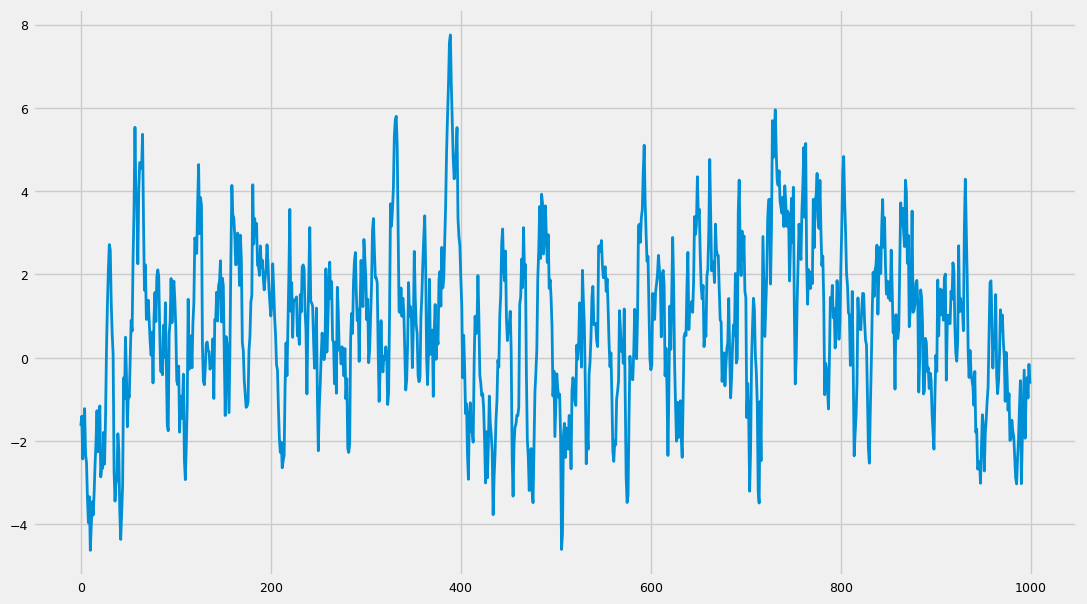

In [4]:
ar1 = np.array([1, -0.9])
ma1 = np.array([1])

AR_object1 = ArmaProcess(ar1, ma1)
simulated_data1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data1)
plt.show();

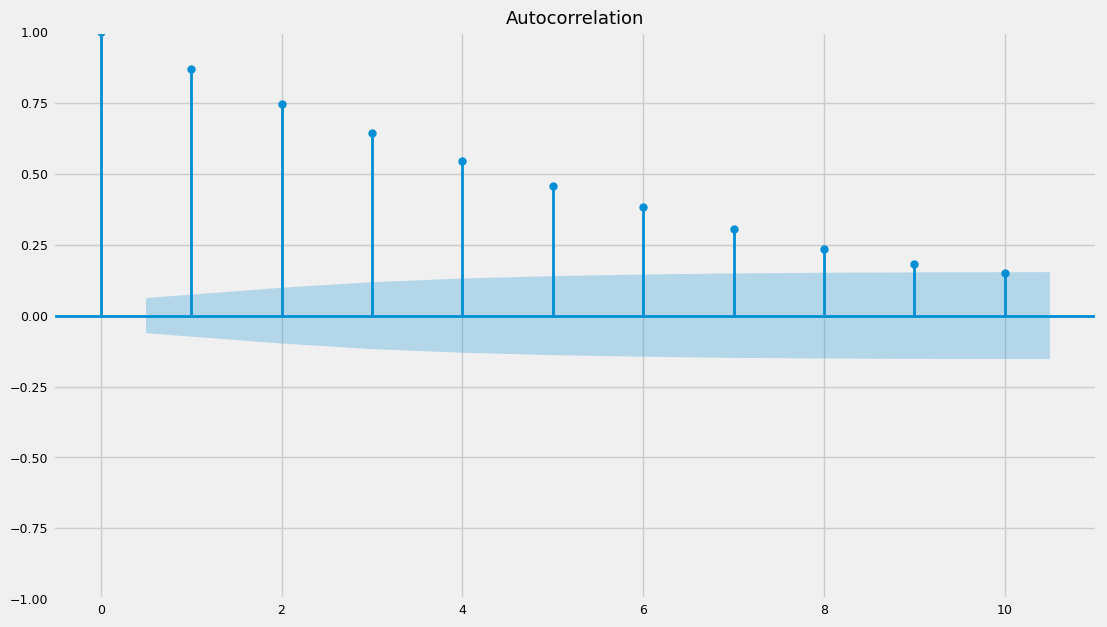

In [5]:
# Plot ACF
plot_acf(simulated_data1, lags=10)
plt.show();

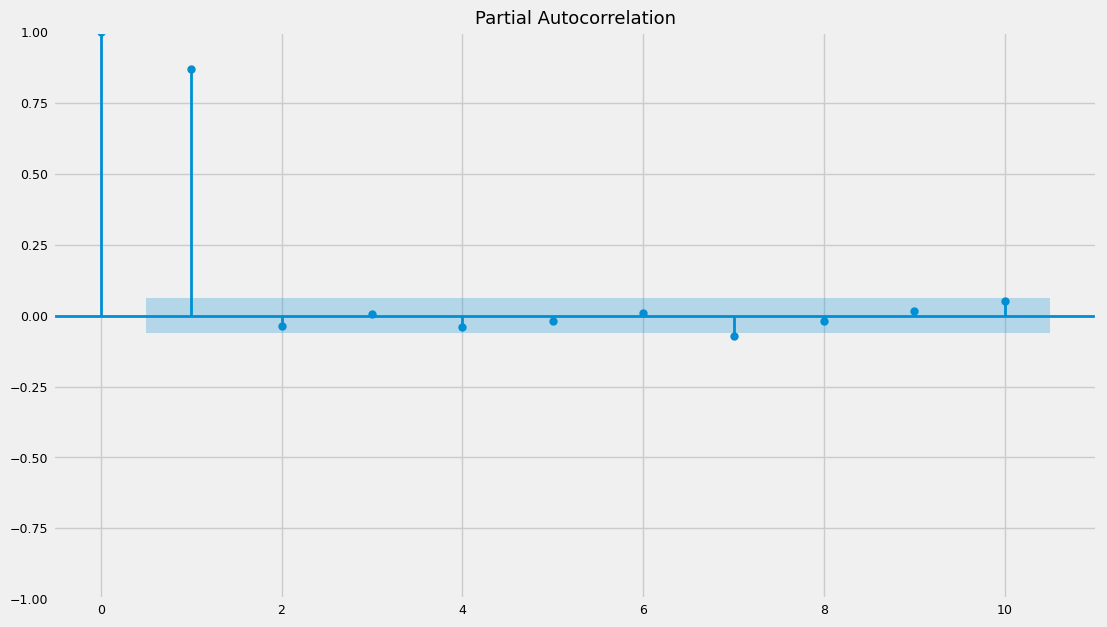

In [6]:
# Plot PACF
plot_pacf(simulated_data1, lags=10)
plt.show();

#### **Intuition**

- The ACF for an Autoregressive process shows strong correlations until the lag `p` and begins to trail off afterwards.
- PACF only describes the relationship between an observation and its lag, suggesting that there may be no correlation for lag values beyond `k`

### **Moving Average Processes**

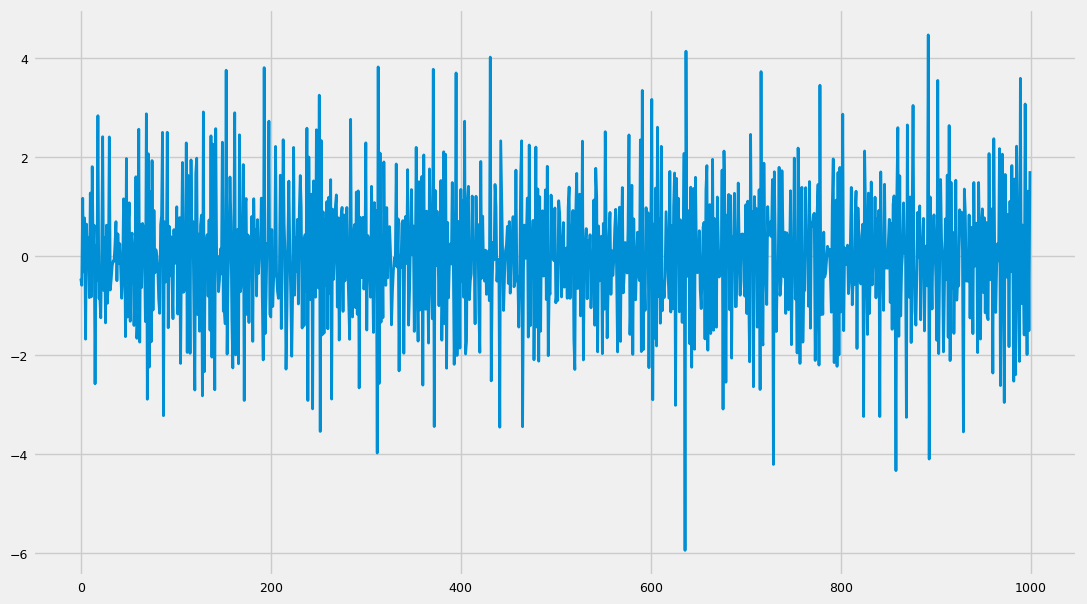

In [7]:
ar1 = np.array([1])
ma1 = np.array([1, -0.9])

MA_object1 = ArmaProcess(ar1, ma1)
simulated_data1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data1)
plt.show();

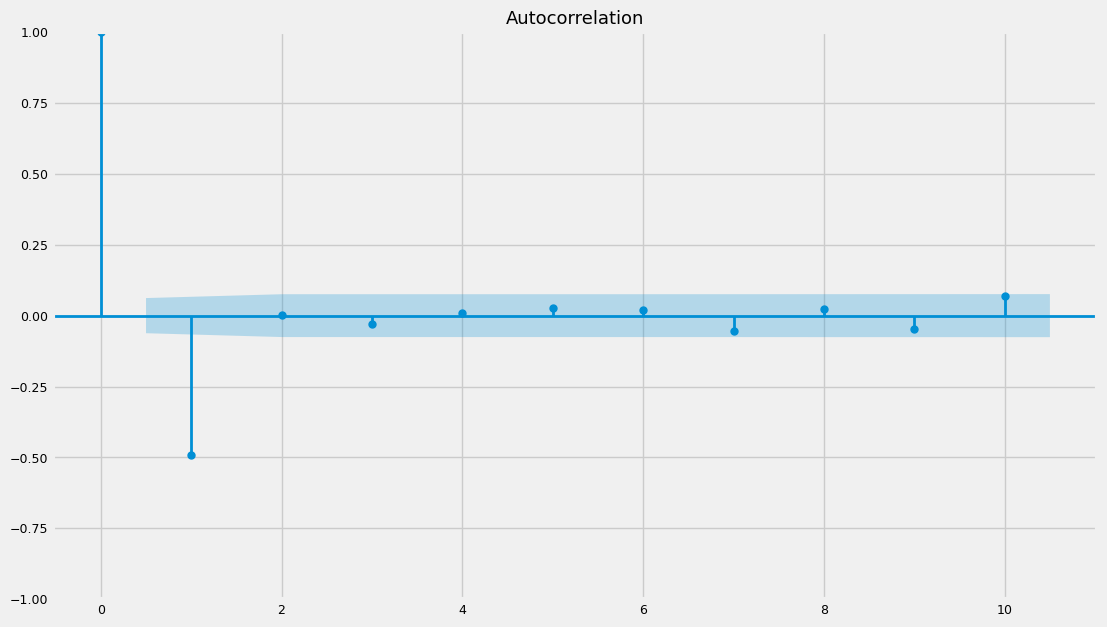

In [8]:
plot_acf(simulated_data1, lags=10)
plt.show();

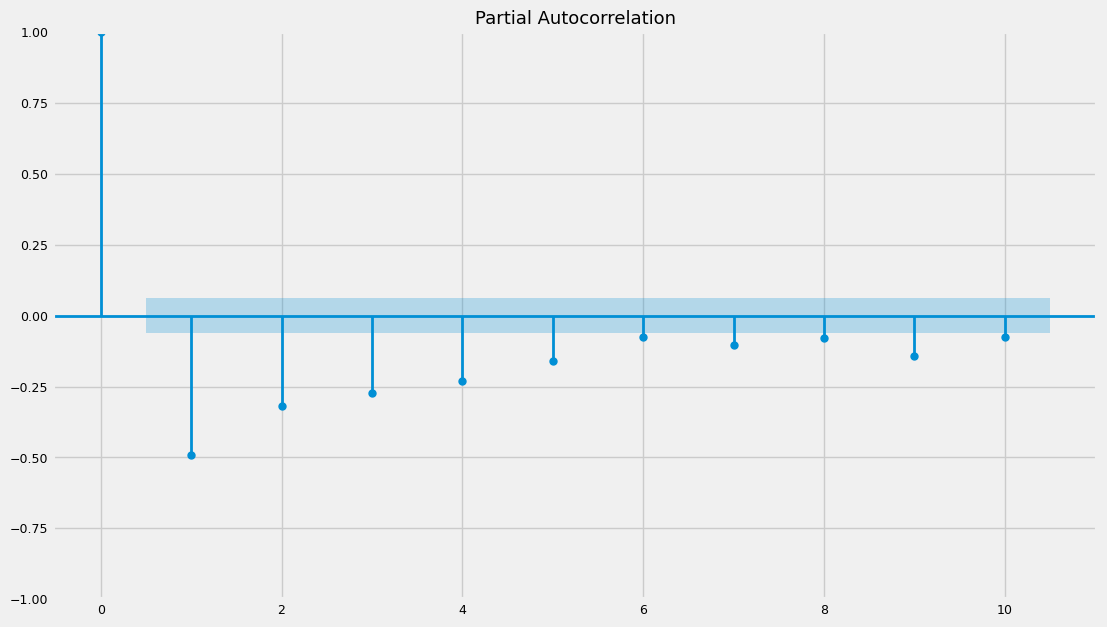

In [9]:
plot_pacf(simulated_data1, lags=10)
plt.show();

#### **Intuition**

- 

### **Forecasting with ARMA**

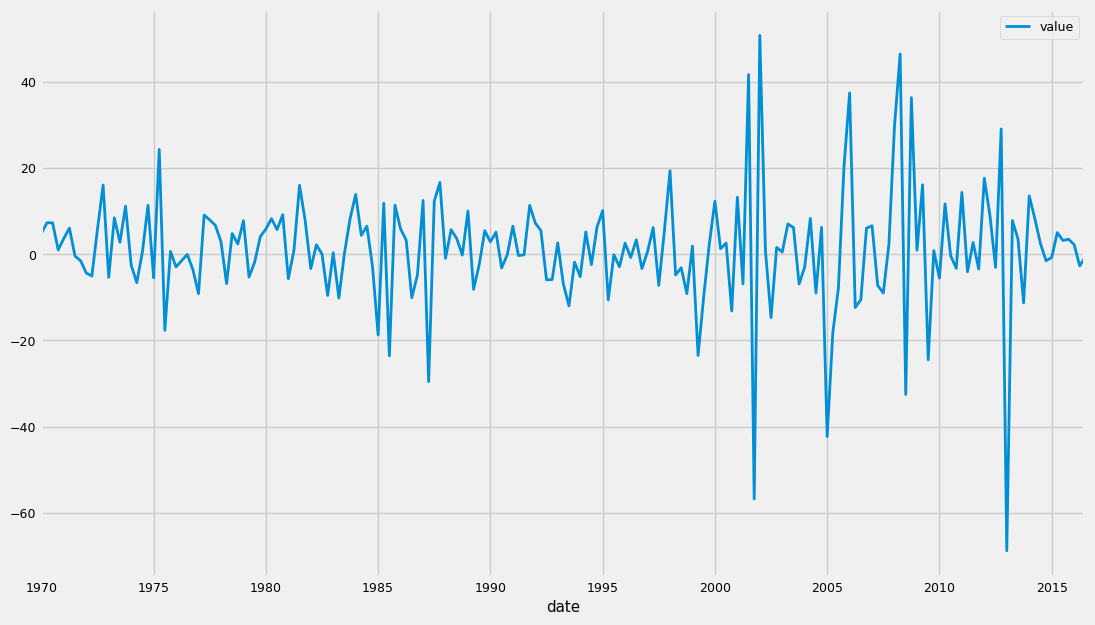

In [10]:
# Loading data
xdat = pd.read_csv(data + 'savings_change.csv')

xdat.columns = ['date', 'value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot();

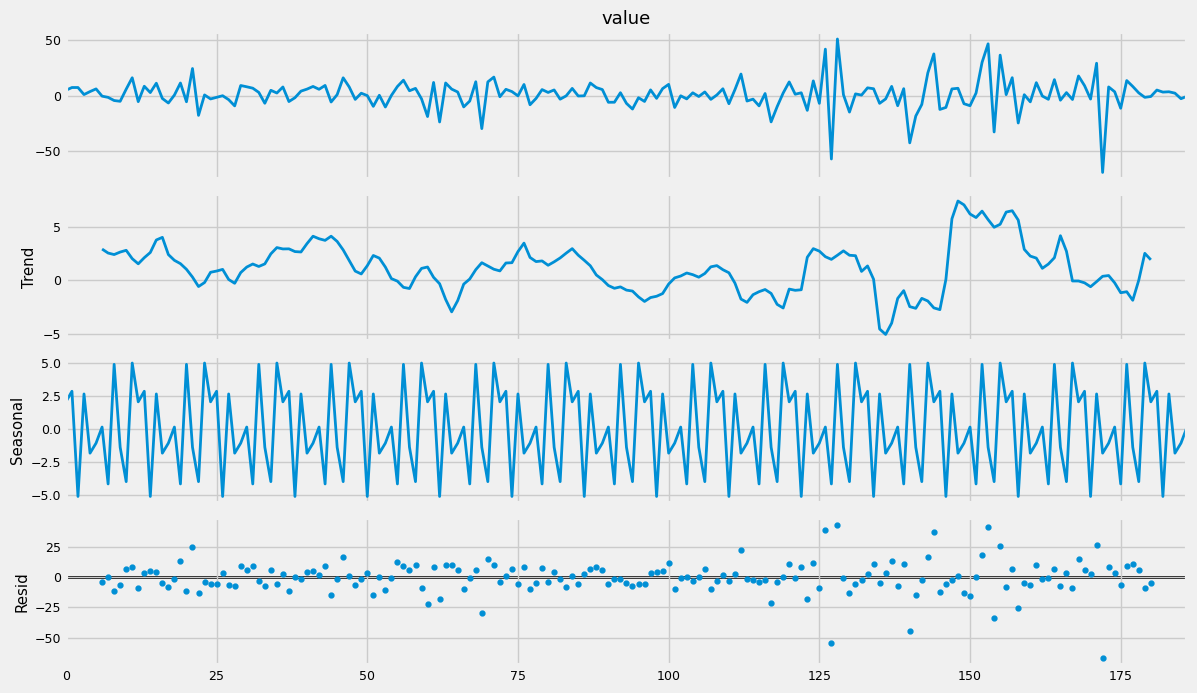

In [11]:
# Seasonal decompostion
decomp = sm.tsa.seasonal_decompose(xdat['value'], period=12, model='additive')
figure = decomp.plot()
plt.show();

In [12]:
# Formal testing of stationarity with the ADF test
val = xdat['value']
result = adfuller(val)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: ')
for k, v in result[4].items():
    print(f'\t{k}: {v.round(4)}')

ADF Statistic: -18.705760292152917
p-value: 2.035863050381184e-30
Critical Values: 
	1%: -3.466
	5%: -2.8772
	10%: -2.5751


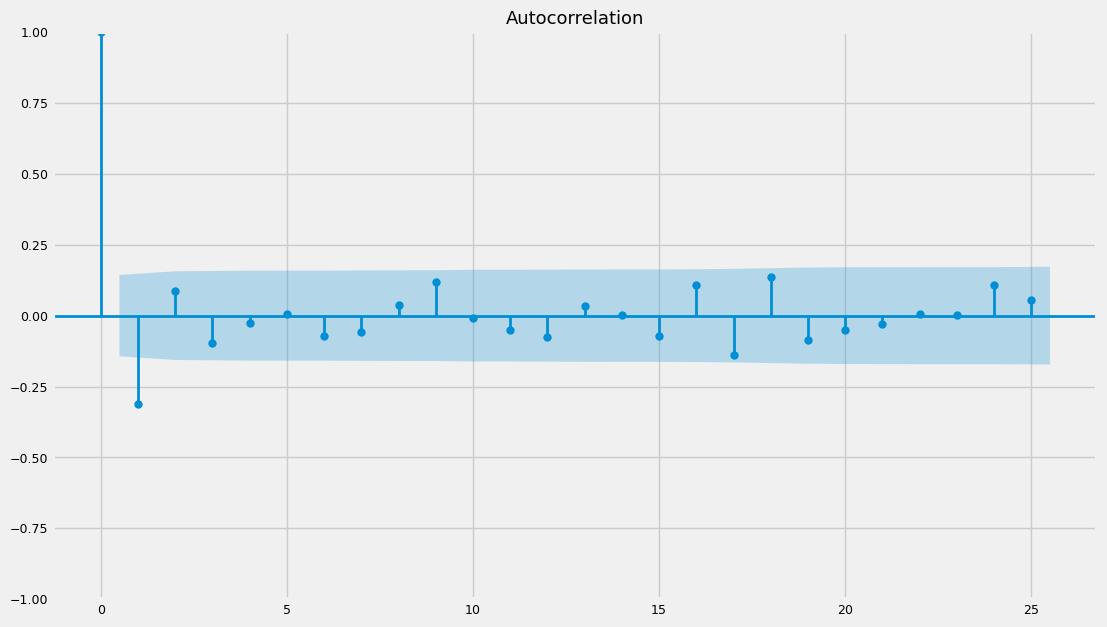

In [13]:
plot_acf(val, lags=25); print()

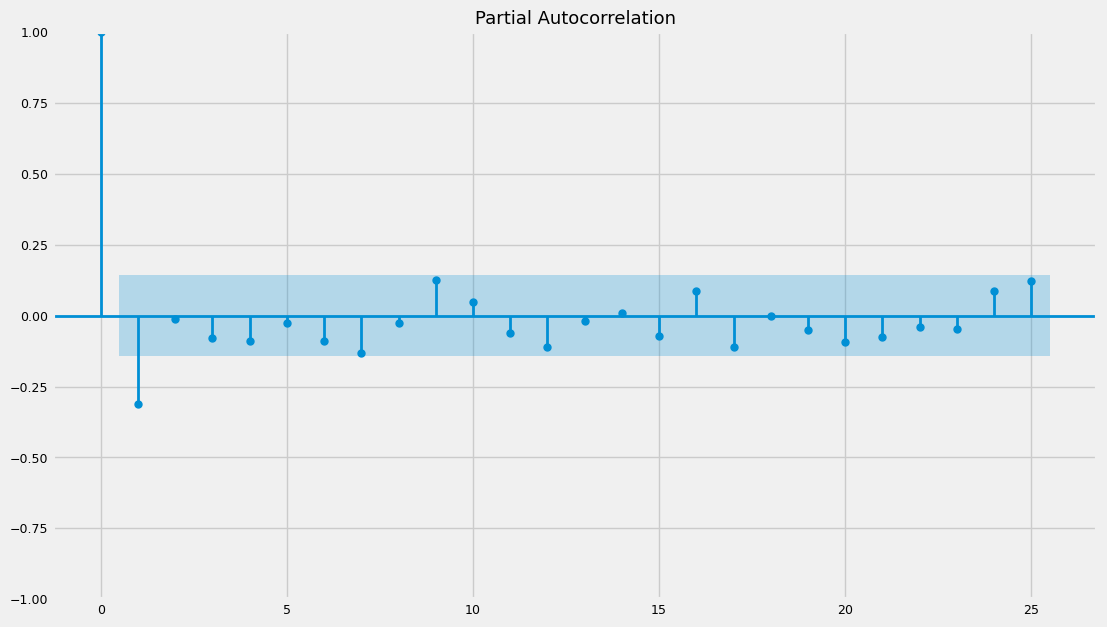

In [14]:
plot_pacf(val, lags=25); print()

In [15]:
# Splitting the data into training and validation, reserving the last 3 for testing
xtrain, xvalid = model_selection.train_test_split(val, test_size=12)

In [16]:
# Create pipeline, pre-process features and fit using the pmdarima lib
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                             seasonal=False, # using Fourier tfms
                             suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1417.652, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1428.604, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.626, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1414.732, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1415.564, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1415.511, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1417.401, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1413.240, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1429.318, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1415.233, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1415.223, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1413.866, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1417.096, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.639 seconds


Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [17]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -699.620
Date:                Fri, 19 Jul 2024   AIC                           1413.240
Time:                        14:41:09   BIC                           1435.394
Sample:                             0   HQIC                          1422.226
                                - 175                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.5503      1.091      1.421      0.155      -0.588       3.689
FOURIER_S4-0     2.2632      1.465      1.545      0.122      -0.609       5.135
FOURIER_C4-0     0.6652      1.497      0.444      0.657      -2.268       3.599
FOURIER_S4-1  9.682e+04   3.97e+05      0.244      0.808   -6.82e+05    8.76e+05
FOURIER_C4-1    -0.0559      4.481     -0.012      0.990      -8.839       8.727
ar.L1           -0.3125      0.043     -7.312      0.000      -0.396      -0.229
sigma2         173.6642     11.068     15.691      0.000     151.972     195.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               206.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
preds, conf_int = pipe.predict(n_periods=xvalid.shape[0], return_conf_int=True)
preds = list(preds)
print("Forecasts:\n", preds)

Forecasts:
 [1.4046903286556864, 2.5881368832219422, 1.7835387623181953, -2.4840312002970344, 3.2962849926599933, 1.9736798616943478, 1.9988512001678336, -2.574599317189959, 3.3478671592405487, 1.9342824236931313, 2.0344401170801145, -2.608998395424072]


In [19]:
print("Confidence Intervals:\n", conf_int)

Confidence Intervals:
 [[-24.42405251  27.23343317]
 [-24.47263543  29.6489092 ]
 [-25.3945784   28.96165593]
 [-29.67358289  24.70552049]
 [-23.89438331  30.4869533 ]
 [-25.2170975   29.16445723]
 [-25.19193682  29.18963922]
 [-29.76538838  24.61618974]
 [-23.842922    30.53865632]
 [-25.25650675  29.12507159]
 [-25.15634905  29.22522929]
 [-29.79978757  24.58179078]]


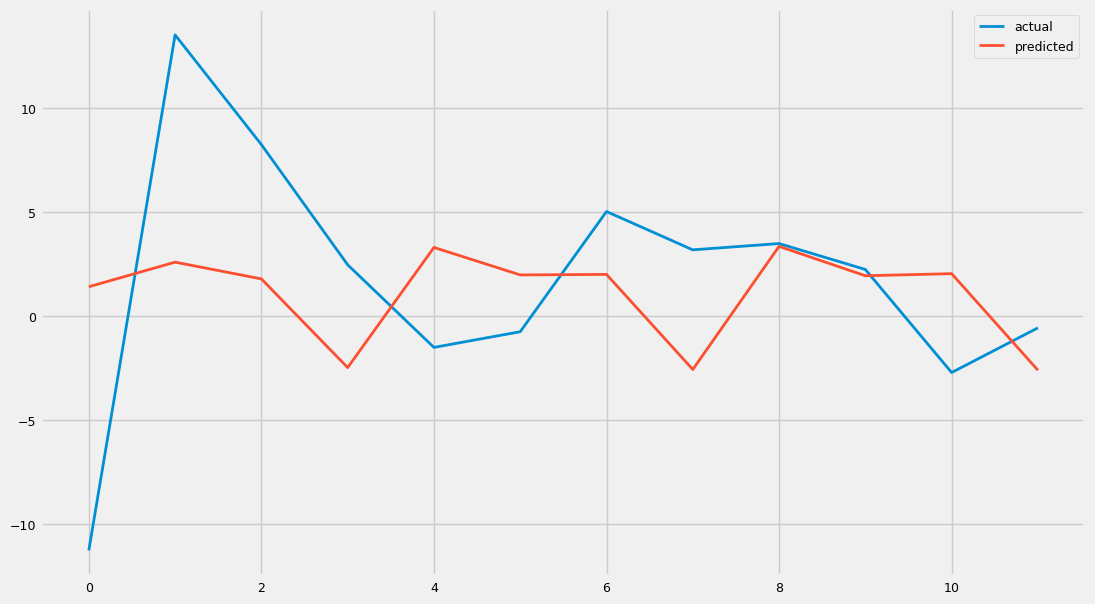

In [20]:
# Visualize the forecast
xvalid = pd.DataFrame(xvalid.values, columns=['actual'])
xvalid['predicted'] = preds
xvalid.plot();

This model's outputs can be useful directionally useful as a baseline, but not much else.

> there is a predictable lag: one period after an increase in the original series the forecast goes up as well; this is due to autoregressive nature of the model.

> the model captures the general dynamics of the model, but struggles with the range of values - this is a consequence of the constant variance assumption.


## **ARIMA - Modelling Beyond ARMA**

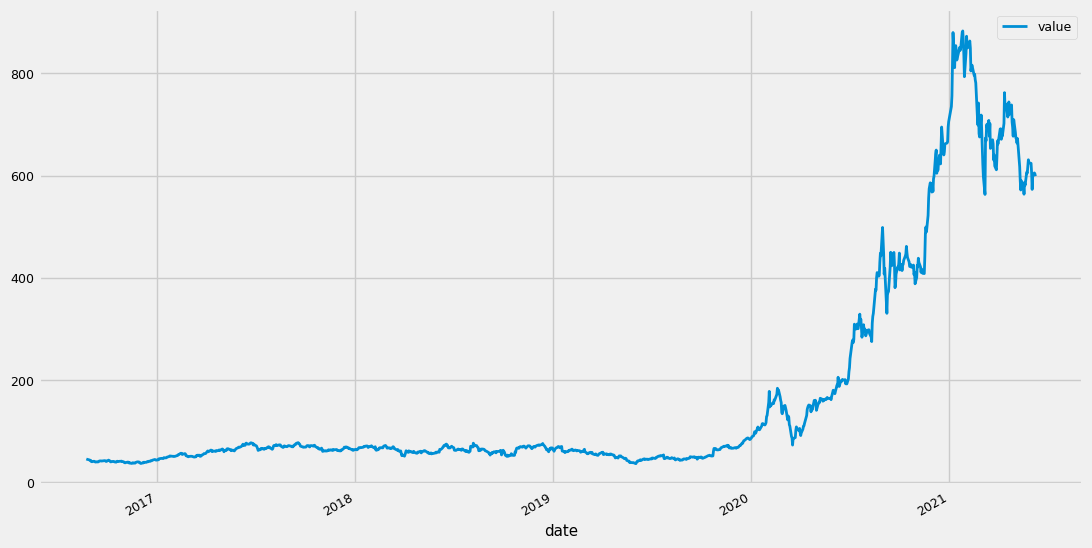

In [22]:
# Let's load Tesla's daily closing stock price on the NYSE
xdat = pd.read_csv(data + 'tesla_prices_5y.csv', usecols=['Date', 'Close'])
xdat.columns = ['date', 'value']

xdat['date'] = pd.to_datetime(xdat['date'])
xdat.set_index('date').plot();

In [25]:
# Applying Dickey-Fuller test to check for stationarity
val = xdat['value']
result = adfuller(val)

print(f'ADF Statistic: {result[0].round(4)}')
print(f'p-value: {result[1].round(4)}')
print(f'Critical Values: ')
for k, v in result[4].items():
    print(f'\t{k}: {v.round(4)}')

ADF Statistic: -0.223
p-value: 0.9357
Critical Values: 
	1%: -3.4359
	5%: -2.864
	10%: -2.5681


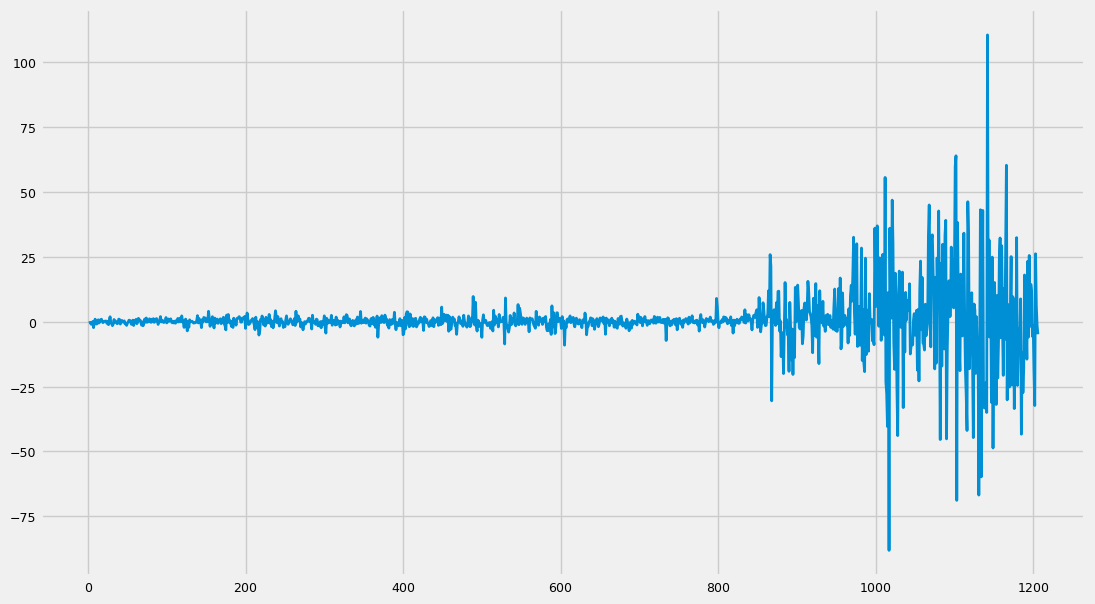

In [26]:
# Using the diff operator to take the difference 
ydat = xdat['value'].diff()
ydat.plot()
print()

In [27]:
# Again, checking for stationarity
result = adfuller(ydat.dropna())

print(f'ADF Statistic: {result[0].round(4)}')
print(f'p-value: {result[1].round(4)}')
print(f'Critical Values: ')
for k, v in result[4].items():
    print(f'\t{k}: {v.round(4)}')

ADF Statistic: -5.9403
p-value: 0.0
Critical Values: 
	1%: -3.4359
	5%: -2.864
	10%: -2.5681


**PROSE - TO DO**

## **SARIMA** - _Incorporating Seasonality_

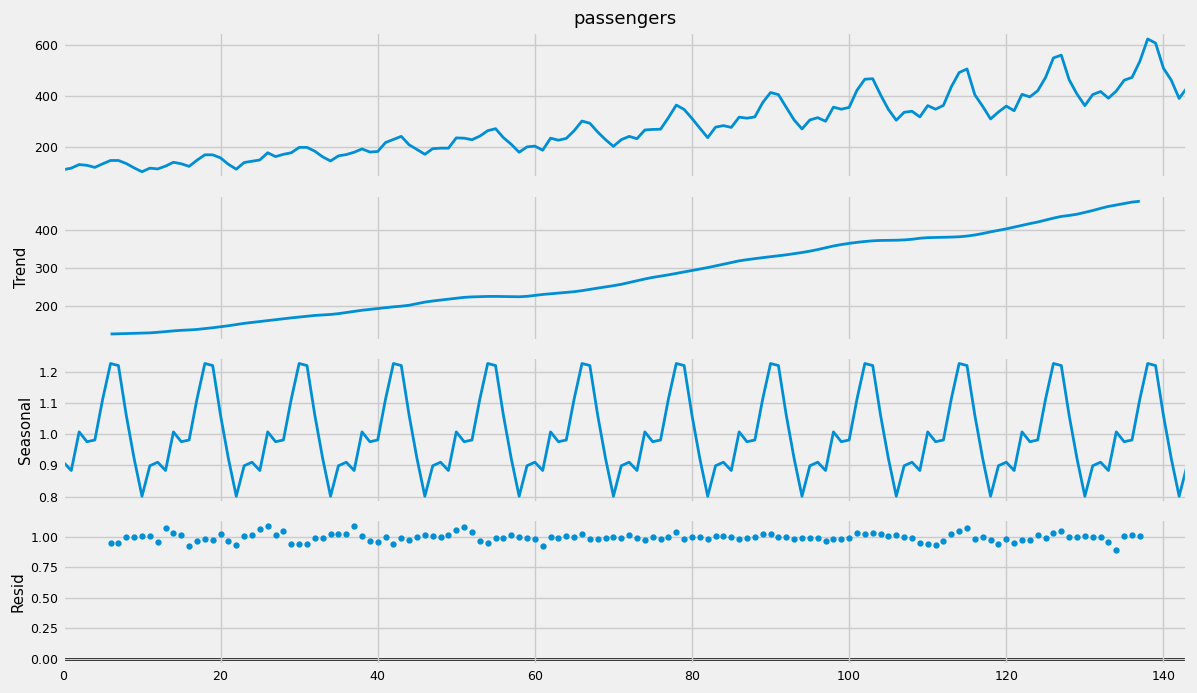

In [28]:
series = pd.read_csv(data + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])

decomp = seasonal_decompose(series['passengers'], period=12, model='multiplicative') 
figure = decomp.plot()
plt.show();